roll no :B20BB030

X = 5, if last digit of your roll no. is even

Y = relu, if last digit of your roll no. is even

# 1 FC layer


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model and the optimizer
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

# Train the model
for epoch in range(10):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        noisy_img = noisy_img.clamp(0, 1)

        optimizer.zero_grad()
        output = model(noisy_img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

    print("Epoch: {} Loss: {}".format(epoch, loss.item()))


Epoch: 0 Loss: 0.03396546095609665
Epoch: 1 Loss: 0.025971902534365654
Epoch: 2 Loss: 0.026905713602900505
Epoch: 3 Loss: 0.027273649349808693
Epoch: 4 Loss: 0.023059533908963203
Epoch: 5 Loss: 0.017630966380238533
Epoch: 6 Loss: 0.020483853295445442
Epoch: 7 Loss: 0.024441448971629143
Epoch: 8 Loss: 0.01650315336883068
Epoch: 9 Loss: 0.018678702414035797


In [ ]:
# Testing the model
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
train_dataset = datasets.FashionMNIST('./data', train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# Remove the decoder part of the autoencoder
encoder = nn.Sequential(*list(model.children())[:-1])

# Define a new fully connected layer for the classification tas
classifier = nn.Sequential(
            nn.Linear(32, 10),
            nn.Softmax(dim=1)
        )

# Define a loss function and optimizer for the classification task
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=0.001)


# Train the classifier using the features from the encoder
losses=[]
for epoch in range(10):
    r=0.0
    for data in train_dataloader:
        img, labels = data
        img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        noisy_img = noisy_img.clamp(0, 1)
        # Use the encoder to extract features from the images
        features = encoder(noisy_img)
        # Forward pass
        output = classifier(features)
        # Compute the loss
        loss = criterion(output, labels)
        # Backward and optimize
        r=r+loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(r/32)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, 50, loss.item()))

epoch [1/50], loss:2.0171
epoch [2/50], loss:1.6989
epoch [3/50], loss:1.7382
epoch [4/50], loss:1.8317
epoch [5/50], loss:1.6107
epoch [6/50], loss:1.6434
epoch [7/50], loss:1.7733
epoch [8/50], loss:1.7712
epoch [9/50], loss:1.7732
epoch [10/50], loss:1.7061


In [ ]:
import matplotlib.pyplot as plt

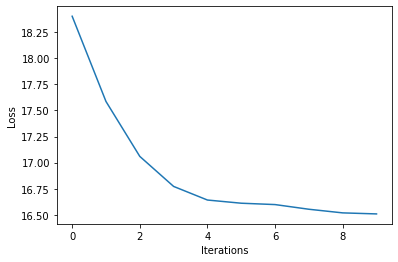

In [ ]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:

correct = 0
total = 0
losses=[]
with torch.no_grad():
    for data in test_dataloader:
        img, label = data
        img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        noisy_img = noisy_img.clamp(0, 1)
        output = classifier(model.encoder(noisy_img))
        loss = criterion(output, label)
        losses.append(loss.item())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print("Test accuracy: {:.2f}%".format(100 * correct / total))

Test accuracy: 76.73%


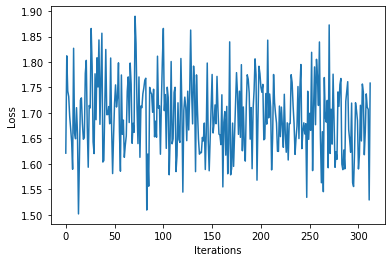

In [ ]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
lt_embed = []
lt_lb = []
ln = 0
with torch.no_grad():
  for img, lb in test_dataloader:
    embed = model.encoder(img.view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break

In [ ]:
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# TSNE PLOT FOR FC1


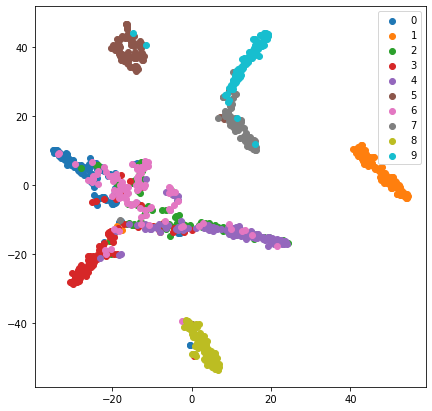

In [ ]:
import numpy as np
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
import torchvision

for img, _ in test_dataset:
  break



In [ ]:

img = img.view(img.size(0), -1)
noise = torch.randn(img.size()) * 0.2
noisy_img = img + noise
noisy_img = noisy_img.clamp(0, 1)

In [ ]:
model.eval()
with torch.no_grad():
  recon = model(noisy_img)

In [ ]:
t=noisy_img.reshape([1,28,28])

In [ ]:
s=recon.reshape([1,28,28])

In [ ]:
t.shape

torch.Size([1, 28, 28])

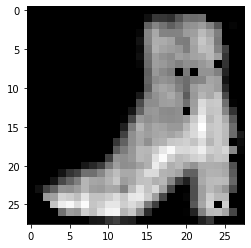

In [ ]:
import torch
import matplotlib.pyplot as plt

# create a tensor with size (1,28,28)


# convert tensor to numpy array
np_image = s.squeeze().numpy()

# display image using matplotlib
plt.imshow(np_image, cmap='gray')
plt.show()


# Reconstructed Image for FC1

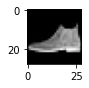

--------------------------


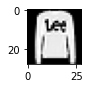

--------------------------


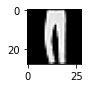

--------------------------


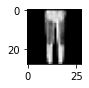

--------------------------


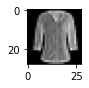

--------------------------


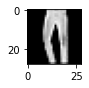

--------------------------


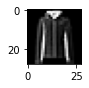

--------------------------


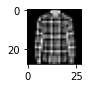

--------------------------


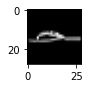

--------------------------


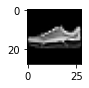

--------------------------


In [ ]:
import torchvision
i=0
for img, _ in test_dataset:
  if(i<10):
    img = img.view(img.size(0), -1)
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    noisy_img = noisy_img.clamp(0, 1)
    model.eval()
    with torch.no_grad():
      recon = model(noisy_img)
    t=img.reshape([1,28,28])
    s=recon.reshape([1,28,28])
    np_image = s.squeeze().numpy()
    tp=t.squeeze().numpy()
    plt.figure(figsize=(1,1))
    plt.imshow(tp, cmap='gray')
    plt.show()

    print("--------------------------")

# display image using matplotlib
    # plt.imshow(np_image, cmap='gray')
    # plt.show()
    i=i+1

  else:
   break

--------------------------


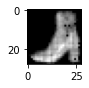

--------------------------


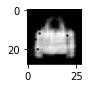

--------------------------


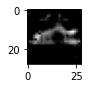

--------------------------


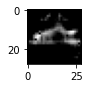

--------------------------


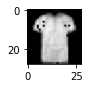

--------------------------


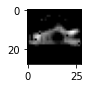

--------------------------


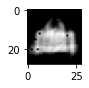

--------------------------


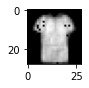

--------------------------


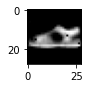

--------------------------


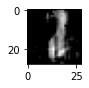

In [ ]:
import torchvision
i=0
for img, _ in test_dataset:
  if(i<10):
    img = img.view(img.size(0), -1)
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    noisy_img = noisy_img.clamp(0, 1)
    model.eval()
    with torch.no_grad():
      recon = model(noisy_img)
    t=img.reshape([1,28,28])
    s=recon.reshape([1,28,28])
    np_image = s.squeeze().numpy()
    # tp=t.squeeze().numpy()
    # plt.imshow(tp, cmap='gray')
    # plt.show()

    print("--------------------------")

# display image using matplotlib
    plt.figure(figsize=(1,1))
    plt.imshow(np_image, cmap='gray')
    plt.show()
    i=i+1

  else:
   break

# 3 FC layer


In [ ]:

# Initialize the model and the optimizer
model2 = Autoencoder()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

# Train the model
for epoch in range(10):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        noisy_img = noisy_img.clamp(0, 1)

        optimizer.zero_grad()
        output = model2(noisy_img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

    print("Epoch: {} Loss: {}".format(epoch, loss.item()))


Epoch: 0 Loss: 0.034783437848091125
Epoch: 1 Loss: 0.02768484130501747
Epoch: 2 Loss: 0.02710201032459736
Epoch: 3 Loss: 0.026055026799440384
Epoch: 4 Loss: 0.0314549095928669
Epoch: 5 Loss: 0.022228354588150978
Epoch: 6 Loss: 0.021971220150589943
Epoch: 7 Loss: 0.020958710461854935
Epoch: 8 Loss: 0.023601166903972626
Epoch: 9 Loss: 0.016815822571516037


In [ ]:
# Remove the decoder part of the autoencoder
encoder2 = nn.Sequential(*list(model2.children())[:-1])

# Define a new fully connected layer for the classification task
classifier2 = nn.Sequential(
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.Linear(16, 12),
           nn.ReLU(),
           nn.Linear(12, 10),
          nn.Softmax(dim=1)
        )

# Define a loss function and optimizer for the classification task
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(encoder2.parameters()) + list(classifier2.parameters()), lr=0.001)


# Train the classifier using the features from the encoder
losses=[]
for epoch in range(10):
    r=0.0
    for data in train_dataloader:
        img, labels = data
        img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        noisy_img = noisy_img.clamp(0, 1)
        # Use the encoder to extract features from the images
        features = encoder2(noisy_img)
        # Forward pass
        output = classifier2(features)
        # Compute the loss
        loss = criterion(output, labels)
        # Backward and optimize
        r=r+loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(r/32)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, 50, loss.item()))

epoch [1/50], loss:1.6618
epoch [2/50], loss:1.9615
epoch [3/50], loss:1.8130
epoch [4/50], loss:1.8306
epoch [5/50], loss:1.8979
epoch [6/50], loss:1.7757
epoch [7/50], loss:1.5873
epoch [8/50], loss:1.6498
epoch [9/50], loss:1.5861
epoch [10/50], loss:1.6512


In [ ]:
import matplotlib.pyplot as plt

# Loss curve FC3


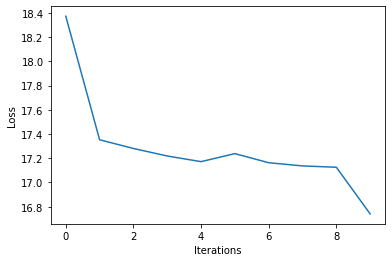

In [ ]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
correct = 0
total = 0
losses=[]
with torch.no_grad():
    for data in test_dataloader:
        img, label = data
        img = img.view(img.size(0), -1)
        noise = torch.randn(img.size()) * 0.2
        noisy_img = img + noise
        noisy_img = noisy_img.clamp(0, 1)
        output = classifier2(model2.encoder(noisy_img))
        loss = criterion(output, label)
        losses.append(loss.item())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print("Test accuracy: {:.2f}%".format(100 * correct / total))

Test accuracy: 77.12%


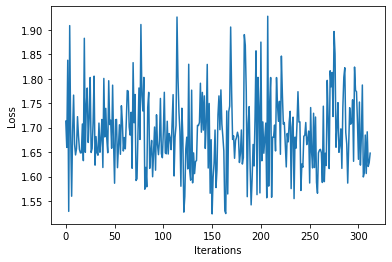

In [ ]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
lt_embed = []
lt_lb = []
ln = 0
with torch.no_grad():
  for img, lb in test_dataloader:
    embed = model2.encoder(img.view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break

In [ ]:
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# TSNE FC3

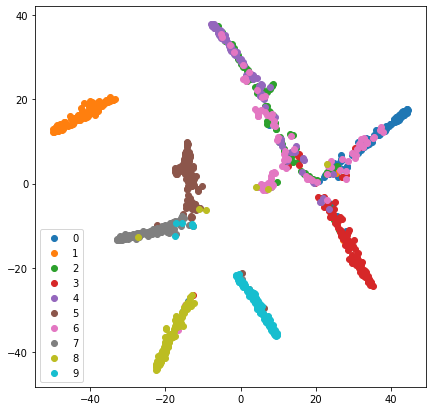

In [ ]:
import numpy as np
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Image reconstruction FC3

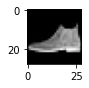

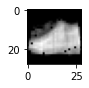

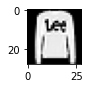

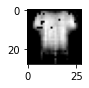

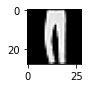

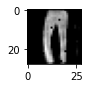

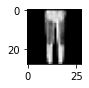

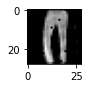

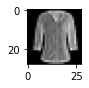

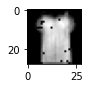

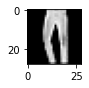

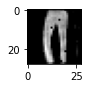

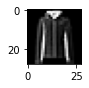

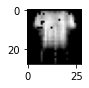

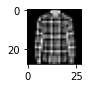

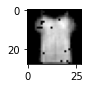

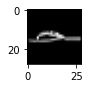

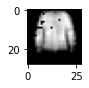

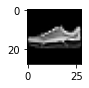

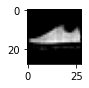

In [ ]:
import torchvision
i=0
for img, _ in test_dataset:
  if(i<10):
    img = img.view(img.size(0), -1)
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    noisy_img = noisy_img.clamp(0, 1)
    model2.eval()
    with torch.no_grad():
      recon = model2(noisy_img)
    t=img.reshape([1,28,28])
    s=recon.reshape([1,28,28])
    np_image = s.squeeze().numpy()
    tp=t.squeeze().numpy()
    plt.figure(figsize=(1,1))
    plt.imshow(tp, cmap='gray')
    plt.show()

# display image using matplotlib
    plt.figure(figsize=(1,1))
    plt.imshow(np_image, cmap='gray')
    plt.show()
    i=i+1

  else:
   break



# Conclusion


The autoencoder trained on 3 FC (Test accuracy: 76.73%)layers for classification performs worse than the autoencoder trained on 3 FC layer (77.12%).
Furthermore, the TSNE plot for 3 FC autoencoder layer appears to have more seperated features






✌